<a class="anchor" id="top"></a>

# Modeling Risk Classification
Author: Ainesh Pandey

In this notebook, we will train and tune several different multi-class modeling approaches to categorize projects into one of the risk classifications generated in the [GenerateRiskTarget notebook](GenerateRiskTarget.ipynb). As a quick reminder, the risk classifications generated are as follows:
- `Risk Class 0`: Catastrophic Failure
- `Risk Class 1`: High-Cost Aviation Projects
- `Risk Class 2`: XYZ
- `Risk Class 4`: Catch-All

## Table of Contents
[Step 1: Import Packages and Data](#step-1) <br>
[Step 2: Helper Functions for Modeling](#step-2) <br>
[Step 3: Prototyping Baseline Solution](#step-3) <br>
[Step 4: Testing Augmented Inputs](#step-4) <br>
[Step 5: Results and Saving Models to Project](#step-5) <br>

<a class="anchor" id="step-1"></a>

## Import Packages and Data

### Packages

We start by importing the required packages for this analysis.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# basic data science packages
import pandas as pd
import numpy as np
np.random.seed(5)

# gensim packages for text preprocessing and LDA
# import gensim
# from gensim.utils import simple_preprocess
# from gensim.parsing.preprocessing import STOPWORDS

# nltk packages for text preprocessing
# import nltk
# from nltk.stem import WordNetLemmatizer
# from nltk.stem.porter import *

# sklearn packages for data preparation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# imblearn packages for handling unbalanced data
import imblearn
from imblearn.under_sampling import OneSidedSelection

# modeling packages
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import statistics

# visualization packages
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# packages to save models to project
import pickle

from scripts.utils import preprocess_prototype, preprocess_augmented

### Data
We import `lessons_learned.csv` and keep all of the data. After some exploratory data analysis, we'll choose which features we will keep as inputs.

In [2]:
df_lessons = pd.read_csv('../Risky Space Business Challenge Files/lessons_learned.csv', encoding='cp1252')

display(df_lessons.shape)
df_lessons.head()

(2101, 17)

,Lesson ID,Title,Abstract,Lesson(s) Learned,Recommendation(s),Organization,Date Lesson Occurred,Driving Event,Evidence,Project / Program,"The related NASA policy(s), standard(s), handbook(s), procedure(s) or other rules",NASA Mission Directorate(s),Sensitivity,From what phase of the program or project was this lesson learned captured?,"Where (other lessons, presentations, publications, etc.)?",Publish Date,Topics
0,30004,Relationship of Government and Contractor Risk...,The purpose of this lesson is to highlight the...,Approach 1 made it difficult to understand the...,Projects should consider RBI's risk management...,LaRC,04/05/2018,"Throughout the project, it was repeatedly dete...",NaN,Radiation Budget Instrument,Langley Management System Center Procedure LMS...,"Aeronautics Research, Human Exploration and Op...",Public,Implementation,LaRC Institutional Knowledge Management (IKM) ...,07/23/2021,"Procurement, Small Business & Industrial Relat..."
1,30101,Cable Harness Wiring and Connector Anomalies C...,Early indications show that the commercial spa...,As a result of many years of expensive lessons...,As commercial vehicles and other NASA vehicles...,NESC,02/28/2021,NASA has found that the commercial spacecraft ...,NaN,"Space Shuttle Program, Commercial Crewed Space...",NaN,Human Exploration and Operations,Public,Implementation » Phase E,NaN,07/23/2021,"Flight Equipment, Ground Operations, Hardware,..."
2,29801,Best Practices for the Elemental Profiling of ...,Trace contaminants in high-purity hydrazine (H...,There was an unexpectedly wide variation in el...,The recommendations to prevent this lesson fro...,NESC,12/14/2020,"Hypergolic propellants (e.g., hydrazine (N2H4)...",NaN,All NASA missions using high purity hydrazine ...,NaN,"Human Exploration and Operations, Science, Spa...",Public,Not Applicable,NaN,06/23/2021,"Ground Operations, Launch Vehicle, Parts, Mate..."
3,29702,Integration and Dependency Between Different A...,During the Radiological Control Center (RADCC)...,"If possible, the design phase of both systems ...",Design phase should incorporate both design te...,KSC,03/15/2020,The RADCC AV system controls and routes variou...,NaN,Radiological Control Center (RADCC),NPR 7120.7A NASA Information Technology Progra...,Human Exploration and Operations,Public,Not Specified,NaN,06/01/2021,"Engineering Design, Integration and Testing, S..."
4,29103,Copper Tube Pinch Failure,While pinching copper tubes is a standard prac...,The pinch was initially visually inspected and...,Have pinch tool operator perform several pract...,KSC,10/17/2020,A copper tube was pinched as a test for the Ma...,Inverted metallography image of separated pinc...,Mass Spectrometer observing lunar operations (...,NaN,"Human Exploration and Operations, Space Techno...",Public,Implementation » Phase D,NaN,12/10/2020,"Engineering Design, Integration and Testing, M..."


Next, we will import `risk_classifications.csv`, which we created in [GenerateRiskTarget.ipynb](GenerateRiskTarget.ipynb).

In [3]:
df_riskclasses = pd.read_csv('../data/risk_classifications.csv')

display(df_riskclasses.shape)
df_riskclasses.head()

(2086, 2)

,Lesson ID,Risk Class
0,30004,4
1,30101,4
2,29801,4
3,29702,4
4,29103,4


We will combine both dataframes into a master dataframe. We also drop any rows where Risk Class == 3, based on our findings in the previous notebook.

In [4]:
df_master = df_lessons.merge(df_riskclasses, on='Lesson ID', how='inner')
df_master = df_master[df_master['Risk Class'] != 3].reset_index()

display(df_master.shape)
df_master.head()

(2067, 19)

,index,Lesson ID,Title,Abstract,Lesson(s) Learned,Recommendation(s),Organization,Date Lesson Occurred,Driving Event,Evidence,Project / Program,"The related NASA policy(s), standard(s), handbook(s), procedure(s) or other rules",NASA Mission Directorate(s),Sensitivity,From what phase of the program or project was this lesson learned captured?,"Where (other lessons, presentations, publications, etc.)?",Publish Date,Topics,Risk Class
0,0,30004,Relationship of Government and Contractor Risk...,The purpose of this lesson is to highlight the...,Approach 1 made it difficult to understand the...,Projects should consider RBI's risk management...,LaRC,04/05/2018,"Throughout the project, it was repeatedly dete...",NaN,Radiation Budget Instrument,Langley Management System Center Procedure LMS...,"Aeronautics Research, Human Exploration and Op...",Public,Implementation,LaRC Institutional Knowledge Management (IKM) ...,07/23/2021,"Procurement, Small Business & Industrial Relat...",4
1,1,30101,Cable Harness Wiring and Connector Anomalies C...,Early indications show that the commercial spa...,As a result of many years of expensive lessons...,As commercial vehicles and other NASA vehicles...,NESC,02/28/2021,NASA has found that the commercial spacecraft ...,NaN,"Space Shuttle Program, Commercial Crewed Space...",NaN,Human Exploration and Operations,Public,Implementation » Phase E,NaN,07/23/2021,"Flight Equipment, Ground Operations, Hardware,...",4
2,2,29801,Best Practices for the Elemental Profiling of ...,Trace contaminants in high-purity hydrazine (H...,There was an unexpectedly wide variation in el...,The recommendations to prevent this lesson fro...,NESC,12/14/2020,"Hypergolic propellants (e.g., hydrazine (N2H4)...",NaN,All NASA missions using high purity hydrazine ...,NaN,"Human Exploration and Operations, Science, Spa...",Public,Not Applicable,NaN,06/23/2021,"Ground Operations, Launch Vehicle, Parts, Mate...",4
3,3,29702,Integration and Dependency Between Different A...,During the Radiological Control Center (RADCC)...,"If possible, the design phase of both systems ...",Design phase should incorporate both design te...,KSC,03/15/2020,The RADCC AV system controls and routes variou...,NaN,Radiological Control Center (RADCC),NPR 7120.7A NASA Information Technology Progra...,Human Exploration and Operations,Public,Not Specified,NaN,06/01/2021,"Engineering Design, Integration and Testing, S...",4
4,4,29103,Copper Tube Pinch Failure,While pinching copper tubes is a standard prac...,The pinch was initially visually inspected and...,Have pinch tool operator perform several pract...,KSC,10/17/2020,A copper tube was pinched as a test for the Ma...,Inverted metallography image of separated pinc...,Mass Spectrometer observing lunar operations (...,NaN,"Human Exploration and Operations, Space Techno...",Public,Implementation » Phase D,NaN,12/10/2020,"Engineering Design, Integration and Testing, M...",4


[Back to Top](#top)

<a class="anchor" id="step-2"></a>

## Helper Functions for Data Prep and Modeling

There are many repetitive steps during data prep and modeling. Here, we will define helper functions to carry out those tasks.

### Data Preparation Helper Functions

#### preprocess()

We start with the `preprocess()` function, which will use the __gensim__ package's `simple_preprocess()` function and perform some additional steps. During the prototyping stage, we can process using the standard parameters for `simple_preprocess()`. However, for the augmented stage, we need to change the standard *max_len* value.

In [5]:
# stemmer = PorterStemmer()

# def preprocess_prototype(text):
#     global stemmer
#     result = ''
#     for token in gensim.utils.simple_preprocess(text):
#         if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
#             result = result + ' ' + stemmer.stem(WordNetLemmatizer().lemmatize(token, pos='v'))
#     return result.strip()

# def preprocess_augmented(text):
#     global stemmer
#     result = ''
#     for token in gensim.utils.simple_preprocess(text, max_len=np.Inf):
#         if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
#             result = result + ' ' + stemmer.stem(WordNetLemmatizer().lemmatize(token, pos='v'))
#     return result.strip()

#### create_pca_representation()

Next, we will write the `create_pca_representation()` function, which will take our preprocessed descriptions, convert them into TF-IDF vectors, and then convert them using PCA into the format needed for further analysis. This function will also return the vectorizers used for both TF-IDF and PCA.

In [5]:
def create_pca_representation(description_col, type):
    if type=='prototype':
        tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range = (1, 2), min_df = 5, max_df=0.5, preprocessor=preprocess_prototype,
                                           stop_words = 'english', strip_accents='unicode', lowercase=True)
    elif type=='augmented':
        tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range = (1, 2), min_df = 5, max_df=0.5, preprocessor=preprocess_augmented,
                                           stop_words = 'english', strip_accents='unicode', lowercase=True)
    pca_vectorizer = PCA(n_components=100, random_state=5)

    tfidf_matrix = tfidf_vectorizer.fit_transform(description_col)
    tfidf_df     = pd.DataFrame(tfidf_matrix.todense())
    pca_matrix   = pca_vectorizer.fit_transform(tfidf_df)

    return pca_matrix, tfidf_vectorizer, pca_vectorizer

#### split_data()

Next, we will write the `split_data()` function, which will use __imblearn__ package's `OneSidedSelection()` function and __sklearn__ package's `train_test_split()` function to split the data into a training set and a testing set.

In [6]:
def split_data(df):
    X = df.drop(['Lesson ID', 'Risk Class'], axis=1)
    y = df['Risk Class']

    X, y = OneSidedSelection(random_state=5).fit_resample(X, y)
    return train_test_split(X, y, test_size=0.3, stratify=y, random_state=5)

### Modeling Helper Functions

#### Create Custom Scorer

Our model tuning will be based on the F1-score metric. However, because our problem is multi-class, we need to specify the _average_ parameter.

In [7]:
scorer = make_scorer(f1_score, average = 'weighted')

#### model_logisticregression_tuned()

The first model we will try to run is a standard `LogisticRegression` model, tuned for the following parameters:
- *solver*: the algorithm to use in the optimization problem
- *penalty*: the norm of the penalty
- *C*: regularization term

In [8]:
def model_logisticregression_tuned(X_train, y_train, X_test, y_test):
    # create parameter grid to fine-tune model
    param_grid = {
        'solver': ['newton-cg', 'lbfgs'],
        'penalty': ['none', 'l2'],
        'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 10.0]
    }

    # run the cross-validated grid search to identify the best parameters for the model
    CV_lm = GridSearchCV(estimator=LogisticRegression(class_weight='balanced', random_state=5),
                        scoring=scorer, param_grid=param_grid, n_jobs=-1, verbose=0).fit(X_train, y_train)

    # extract the best parameters, as selected by the grid search
    best_params = CV_lm.best_params_
    best_solver = best_params['solver']
    best_penalty = best_params['penalty']
    best_C = best_params['C']
    print(best_params)

    # create the final LogisticRegression
    best_lm = LogisticRegression(class_weight='balanced', random_state=5,
                                solver=best_solver,
                                penalty=best_penalty,
                                C=best_C).fit(X_train, y_train)
    lm_pred = best_lm.predict(X_test)

    # track other related model performance metrics
    lm_metrics = classification_report(y_test, lm_pred, digits=3)
    
    # return the model and the confusion matrix
    return best_lm, lm_pred, lm_metrics

#### model_randomforestclassifier_tuned()

The next model we will try to run is a `RandomForestClassifier` model, tuned for the following parameters:
- *n_estimators*: the number of trees in the forest
- *max_features*: the number of features to consider when looking for the best split
- *max_depth*: the maximum depth of the tree
- *criterion*: the function to measure the quality of a split

In [9]:
def model_randomforestclassifier_tuned(X_train, y_train, X_test, y_test):
    # create parameter grid to fine-tune model
    param_grid = { 
        'n_estimators': range(100, 400, 100),
        'max_features': ['auto', 'log2', 0.25, 0.33, 0.5],
        'max_depth' : [None, 5, 8],
        'criterion' : ['gini', 'entropy']
    }

    # get balanced sample weights
    sample = class_weight.compute_sample_weight('balanced', y_train)

    # run the cross-validated grid search to identify the best parameters for the model
    CV_rfc = GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced', random_state=5), scoring=scorer,
                        param_grid=param_grid, n_jobs=-1, verbose=2).fit(X_train, y_train, sample_weight=sample)

    # extract the best parameters, as selected by the grid search
    best_params = CV_rfc.best_params_
    best_n_estimators = best_params['n_estimators']
    best_max_features = best_params['max_features']
    best_max_depth = best_params['max_depth']
    best_criterion = best_params['criterion']
    print(best_params)

    # create the final RandomForestClassifier
    best_rfc = RandomForestClassifier(class_weight='balanced', random_state=5,
                                    max_features=best_max_features,
                                    n_estimators=best_n_estimators,
                                    max_depth=best_max_depth,
                                    criterion=best_criterion).fit(X_train, y_train, sample_weight=sample)
    rfc_pred = best_rfc.predict(X_test)

    # track other related model performance metrics
    rfc_metrics = classification_report(y_test, rfc_pred, digits=3)

    # return the model and the confusion matrix
    return best_rfc, rfc_pred, rfc_metrics

#### model_lgbmclassifier_tuned()

The next model we will try to run is a `LGBMClassifier` model, tuned for the following parameters:
- *max_depth*: maximum tree depth for base learners, <=0 means no limit
- *num_leaves*: maximum tree leaves for base learners
- *reg_alpha*: L1 regularization term on weights
- *reg_lambda*: L2 regularization term on weights
- *min_split_gain*: minimum loss reduction required to make a further partition on a leaf node of the tree

In [10]:
def model_lgbmclassifier_tuned(X_train, y_train, X_test, y_test):
    # create parameter grid to fine-tune model
    param_grid = {
        'max_depth': [15, 20, -1],
        'num_leaves': [10, 20, 30],
        'reg_alpha': [0, 0.5, 1.0],
        'reg_lambda': [0, 0.5, 1.0],
        'min_split_gain': [0, 0.2, 0.4]
    }

    # run the cross-validated grid search to identify the best parameters for the model
    CV_lgb = GridSearchCV(estimator=LGBMClassifier(class_weight='balanced', random_state=5), scoring=scorer,
                        param_grid=param_grid, n_jobs=-1, verbose=2).fit(X_train, y_train)

    # extract the best parameters, as selected by the grid search
    best_params = CV_lgb.best_params_
    best_max_depth = best_params['max_depth']
    best_num_leaves = best_params['num_leaves']
    best_reg_alpha = best_params['reg_alpha']
    best_reg_lambda = best_params['reg_lambda']
    best_min_split_gain = best_params['min_split_gain']
    print(best_params)

    # create the final LGBMClassifier
    best_lgb = LGBMClassifier(class_weight='balanced', random_state=5,
                            max_depth=best_max_depth,
                            num_leaves=best_num_leaves,
                            reg_alpha=best_reg_alpha,
                            reg_lambda=best_reg_lambda,
                            min_split_gain=best_min_split_gain).fit(X_train, y_train)
    lgb_pred = best_lgb.predict(X_test)

    # track other related model performance metrics
    lgb_metrics = classification_report(y_test, lgb_pred, digits=3)

    # return the model and the confusion matrix
    return best_lgb, lgb_pred, lgb_metrics

#### model_knnclassifier_tuned()

The next model we will try to run is a `KNeighborsClassifier` model, tuned for the following parameters:
- *n_neighbors*: number of neighbors
- *weights*: weight function used in prediction
- *algorithm*: algorithm used to compute the nearest neighbors
- *p*: power parameter for the Minkowski metric (1=L1, 2=L2, 3=L_3 for Minkowski)

In [11]:
def model_knnclassifier_tuned(X_train, y_train, X_test, y_test):
    # create parameter grid to fine-tune model
    param_grid = {
        'n_neighbors': [1, 3, 5],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'p': [1, 2, 3]
    }

    # run the cross-validated grid search to identify the best parameters for the model
    CV_knn = GridSearchCV(estimator=KNeighborsClassifier(), scoring=scorer,
                        param_grid=param_grid, n_jobs=-1, verbose=2).fit(X_train, y_train)

    # extract the best parameters, as selected by the grid search
    best_params = CV_knn.best_params_
    best_n_neighbors = best_params['n_neighbors']
    best_weights = best_params['weights']
    best_algorithm = best_params['algorithm']
    best_p = best_params['p']
    print(best_params)

    # create the final KNeighborsClassifier
    best_knn = KNeighborsClassifier(n_neighbors=best_n_neighbors,
                            weights=best_weights,
                            algorithm=best_algorithm,
                            p=best_p).fit(X_train, y_train)
    knn_pred = best_knn.predict(X_test)

    # track other related model performance metrics
    knn_metrics = classification_report(y_test, knn_pred, digits=3)

    # return the model and the confusion matrix
    return best_knn, knn_pred, knn_metrics

#### model_gnbclassifier_tuned()

The final model we will try to run is a `GaussianNB` model, tuned for the following parameters:
- *var_smoothing*: portion of the largest variance of all features that is added to variances for calculation stability

In [12]:
from sklearn.utils import class_weight

def model_gnbclassifier_tuned(X_train, y_train, X_test, y_test):
    # create parameter grid to fine-tune model
    param_grid = {
        'var_smoothing': np.logspace(0,-9, num=20)
    }

    # get balanced sample weights
    sample = class_weight.compute_sample_weight('balanced', y_train)

    # run the cross-validated grid search to identify the best parameters for the model
    CV_gnb = GridSearchCV(estimator=GaussianNB(), scoring=scorer,
                          param_grid=param_grid, n_jobs=-1, verbose=2).fit(X_train, y_train, sample_weight=sample)

    # extract the best parameters, as selected by the grid search
    best_params = CV_gnb.best_params_
    best_var_smoothing = best_params['var_smoothing']
    print(best_params)

    # create the final GaussianNB classifier
    best_gnb = GaussianNB(var_smoothing=best_var_smoothing).fit(X_train, y_train, sample_weight=sample)
    gnb_pred = best_gnb.predict(X_test)

    # track other related model performance metrics
    gnb_metrics = classification_report(y_test, gnb_pred, digits=3)

    # return the model and the confusion matrix
    return best_gnb, gnb_pred, gnb_metrics

#### print_cms()

The `print_cms()` function will print out the confusion matrices for all of the models we have run side-by-side for easier interpretation.

In [13]:
def print_cms(pred_dict, y_test, normalize=None):
    f, axes = plt.subplots(3, 3, figsize=(20, 15), sharey='row')

    i = 0
    for alg, pred in pred_dict.items():
        x = int(i/3)
        y = i%3

        disp = ConfusionMatrixDisplay(confusion_matrix(y_test, pred, normalize=normalize))
        disp.plot(ax=axes[x, y], xticks_rotation=45, cmap=plt.cm.Blues)
        disp.ax_.set_title(alg)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')

        i += 1

    f.text(0.42, 0.09, 'Predicted label', ha='left')
    f.colorbar(disp.im_, ax=axes)
    plt.show()

[Back to Top](#top)

<a class="anchor" id="step-3"></a>

## Prototyping Baseline Solution

The problem at hand is a classification task; we want to use data available about projects before they are officially launched to predict what class of risk they fall under. Therefore, we intend to generate a text-based description of each project, carry out basic NLP transformations to convert the descriptions into tabular data, and utilize several different multi-class classification algorithms to try to accurately predict which class of risk each project is likely to fall under.

### Prep Dataframe for Prototyping

We will create a prototype of the classification model using just the _Title_ and _Abstract_. Depending on the performance of the model, we may augment the inputs with other features as needed.

First, we need to drop all irrelevant columns.

In [14]:
df_prototyping = df_master[['Lesson ID', 'Title', 'Abstract', 'Risk Class']]

display(df_prototyping.shape)
df_prototyping.head()

(2067, 4)

,Lesson ID,Title,Abstract,Risk Class
0,30004,Relationship of Government and Contractor Risk...,The purpose of this lesson is to highlight the...,4
1,30101,Cable Harness Wiring and Connector Anomalies C...,Early indications show that the commercial spa...,4
2,29801,Best Practices for the Elemental Profiling of ...,Trace contaminants in high-purity hydrazine (H...,4
3,29702,Integration and Dependency Between Different A...,During the Radiological Control Center (RADCC)...,4
4,29103,Copper Tube Pinch Failure,While pinching copper tubes is a standard prac...,4


Next, we need to combine the _Title_ and _Abstract_ into one block of text.

In [15]:
if 'Title' in df_prototyping.columns:
    df_prototyping['Description'] = df_prototyping['Title'].astype(str) + ' ' + df_prototyping['Abstract'].astype(str)
    df_prototyping.drop(['Title', 'Abstract'], axis=1, inplace=True)

display(df_prototyping.shape)
df_prototyping.head()

(2067, 3)

,Lesson ID,Risk Class,Description
0,30004,4,Relationship of Government and Contractor Risk...
1,30101,4,Cable Harness Wiring and Connector Anomalies C...
2,29801,4,Best Practices for the Elemental Profiling of ...
3,29702,4,Integration and Dependency Between Different A...
4,29103,4,Copper Tube Pinch Failure While pinching coppe...


We need to do our usual data preprocessing steps and extract a PCA representation of each _Description_ using our `create_pca_representation()` helper function. We will replace the _Description_ column with this PCA representation.

In [16]:
if 'Description' in df_prototyping.columns:
    pca_matrix, tfidf_vectorizer, pca_vectorizer = create_pca_representation(df_prototyping['Description'], 'prototype')
    df_prototyping.drop('Description', axis=1, inplace=True)
    df_prototyping = pd.concat([df_prototyping, pd.DataFrame(pca_matrix)], axis=1)

display(df_prototyping.shape)
df_prototyping.head()

(2067, 102)

,Lesson ID,Risk Class,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,30004,4,-0.033854,0.082005,0.259533,0.067744,0.047458,-0.047642,-0.051692,0.031634,...,0.019679,-0.015403,0.036234,-0.084950,-0.029656,0.033625,0.001141,-0.062345,0.025706,-0.034294
1,30101,4,0.100768,-0.114094,0.037132,-0.092427,0.037966,-0.012349,0.005554,-0.059482,...,-0.045800,0.118993,0.021418,0.100452,-0.092462,-0.006570,0.046110,-0.038476,0.038111,0.053453
2,29801,4,-0.063784,0.006688,-0.007435,-0.019258,-0.015219,-0.060059,0.013481,-0.061282,...,0.043561,-0.020959,-0.001669,0.007417,0.032759,0.021461,-0.037661,-0.032862,0.047159,0.027639
3,29702,4,-0.034003,0.000247,-0.011641,-0.089555,0.108049,0.064706,-0.057105,-0.028622,...,-0.001350,-0.021536,0.085029,0.035786,-0.122584,0.009606,0.091326,-0.005283,-0.045413,-0.009746
4,29103,4,-0.051290,-0.010528,-0.037038,-0.011080,-0.020117,-0.037159,0.022863,-0.037152,...,0.018976,0.082383,-0.059004,-0.073744,-0.074187,0.030126,-0.114796,0.099240,0.010487,0.045370


We now split the data into a training and testing set using the `split_data()` helper function.

In [18]:
X_train, X_test, y_train, y_test = split_data(df_prototyping)

print('Training Output Variable Distribution')
display(y_train.value_counts())
print()
print('Testing Output Variable Distribution')
display(y_test.value_counts())


Training Output Variable Distribution


4    989
0    258
2     66
1      7
Name: Risk Class, dtype: int64


Testing Output Variable Distribution


4    425
0    111
2     28
1      3
Name: Risk Class, dtype: int64

### Multi-Class Modeling on Prototype

Now that the data has been prepared, we are ready to try out some multi-class modeling algorithms. We will train and tune a wide gamut of modeling techniques to determine which approach (if any) most correctly and efficiently categorizes the risk of each project. As a reminder, the risk classifications are as follows:
- `Risk Class 0`: Catastrophic Failure
- `Risk Class 1`: High-Cost Aviation Projects
- `Risk Class 2`: XYZ
- `Risk Class 4`: Catch-All
<br><br>

***
#### Logistic Regression
***

In [19]:
best_lm, lm_pred, lm_metrics = model_logisticregression_tuned(X_train, y_train, X_test, y_test)
print(lm_metrics)

{'C': 10.0, 'penalty': 'l2', 'solver': 'newton-cg'}
              precision    recall  f1-score   support

           0      0.481     0.694     0.568       111
           1      0.133     0.667     0.222         3
           2      0.176     0.571     0.269        28
           4      0.940     0.666     0.780       425

    accuracy                          0.667       567
   macro avg      0.433     0.649     0.460       567
weighted avg      0.808     0.667     0.710       567



***
#### Random Forest Classifier
***

In [20]:
best_rfc, rfc_pred, rfc_metrics = model_randomforestclassifier_tuned(X_train, y_train, X_test, y_test)
print(rfc_metrics)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'criterion': 'entropy', 'max_depth': 8, 'max_features': 0.5, 'n_estimators': 200}
              precision    recall  f1-score   support

           0      0.616     0.622     0.619       111
           1      0.500     0.667     0.571         3
           2      0.500     0.214     0.300        28
           4      0.868     0.896     0.882       425

    accuracy                          0.808       567
   macro avg      0.621     0.600     0.593       567
weighted avg      0.798     0.808     0.800       567



***
#### Light Gradient Boosted Model Classifier
***

In [21]:
best_lgb, lgb_pred, lgb_metrics = model_lgbmclassifier_tuned(X_train, y_train, X_test, y_test)
print(lgb_metrics)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
{'max_depth': 15, 'min_split_gain': 0, 'num_leaves': 10, 'reg_alpha': 0.5, 'reg_lambda': 0.5}
              precision    recall  f1-score   support

           0      0.587     0.667     0.624       111
           1      0.500     0.667     0.571         3
           2      0.381     0.286     0.327        28
           4      0.885     0.866     0.875       425

    accuracy                          0.797       567
   macro avg      0.588     0.621     0.599       567
weighted avg      0.800     0.797     0.797       567



***
#### K Nearest Neighbors Classifier
***

In [22]:
best_knn, knn_pred, knn_metrics = model_knnclassifier_tuned(X_train, y_train, X_test, y_test)
print(knn_metrics)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'algorithm': 'auto', 'n_neighbors': 3, 'p': 3, 'weights': 'distance'}
              precision    recall  f1-score   support

           0      0.504     0.523     0.513       111
           1      0.667     0.667     0.667         3
           2      0.261     0.214     0.235        28
           4      0.845     0.847     0.846       425

    accuracy                          0.751       567
   macro avg      0.569     0.563     0.565       567
weighted avg      0.749     0.751     0.750       567



***
#### Gaussian Naive Bayes Classifier
***

In [23]:
best_gnb, gnb_pred, gnb_metrics = model_gnbclassifier_tuned(X_train, y_train, X_test, y_test)
print(gnb_metrics)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'var_smoothing': 0.012742749857031341}
              precision    recall  f1-score   support

           0      0.411     0.559     0.473       111
           1      0.080     0.667     0.143         3
           2      0.131     0.571     0.213        28
           4      0.926     0.586     0.718       425

    accuracy                          0.580       567
   macro avg      0.387     0.596     0.387       567
weighted avg      0.781     0.580     0.642       567



All of our models seem to do well in different areas of the input space. We think we can yield better results by ensembling our different models.
<br><br>

***
#### Custom Ensembles
***

In [24]:
# create a custom ensemble of all of the above methods
estimators_all = [('lm', best_lm), ('rfc', best_rfc), ('lgb', best_lgb), ('knn', best_knn), ('gnb', best_gnb)]
ensemble_all = VotingClassifier(estimators_all, voting='soft')

#fit model to training data
ensemble_all.fit(X_train, y_train)
pred_all = ensemble_all.predict(X_test)

print(classification_report(y_test, pred_all, digits=3))


              precision    recall  f1-score   support

           0      0.595     0.676     0.633       111
           1      0.500     0.667     0.571         3
           2      0.478     0.393     0.431        28
           4      0.896     0.873     0.884       425

    accuracy                          0.810       567
   macro avg      0.617     0.652     0.630       567
weighted avg      0.814     0.810     0.811       567



In [25]:
# create a custom ensemble of all models except for RFC
estimators_sans_rfc = [('lm', best_lm), ('lgb', best_lgb), ('knn', best_knn), ('gnb', best_gnb)]
ensemble_sans_rfc = VotingClassifier(estimators_sans_rfc, voting='soft')

#fit model to training data
ensemble_sans_rfc.fit(X_train, y_train)
pred_sans_rfc = ensemble_sans_rfc.predict(X_test)

print(classification_report(y_test, pred_sans_rfc, digits=3))

              precision    recall  f1-score   support

           0      0.559     0.640     0.597       111
           1      0.500     0.667     0.571         3
           2      0.481     0.464     0.473        28
           4      0.892     0.859     0.875       425

    accuracy                          0.795       567
   macro avg      0.608     0.657     0.629       567
weighted avg      0.805     0.795     0.799       567



In [26]:
# create a custom ensemble of all models except for LGBM
estimators_sans_lgb = [('lm', best_lm), ('rfc', best_rfc), ('knn', best_knn), ('gnb', best_gnb)]
ensemble_sans_lgb = VotingClassifier(estimators_sans_lgb, voting='soft')

#fit model to training data
ensemble_sans_lgb.fit(X_train, y_train)
pred_sans_lgb = ensemble_sans_lgb.predict(X_test)

print(classification_report(y_test, pred_sans_lgb, digits=3))

              precision    recall  f1-score   support

           0      0.540     0.667     0.597       111
           1      0.400     0.667     0.500         3
           2      0.412     0.500     0.452        28
           4      0.898     0.826     0.860       425

    accuracy                          0.778       567
   macro avg      0.562     0.665     0.602       567
weighted avg      0.801     0.778     0.787       567



In [27]:
# create a custom ensemble of all models except for KNN
estimators_sans_knn = [('lm', best_lm), ('rfc', best_rfc), ('lgb', best_lgb), ('gnb', best_gnb)]
ensemble_sans_knn = VotingClassifier(estimators_sans_knn, voting='soft')

#fit model to training data
ensemble_sans_knn.fit(X_train, y_train)
pred_sans_knn = ensemble_sans_knn.predict(X_test)

print(classification_report(y_test, pred_sans_knn, digits=3))

              precision    recall  f1-score   support

           0      0.543     0.676     0.602       111
           1      0.500     0.667     0.571         3
           2      0.375     0.429     0.400        28
           4      0.898     0.831     0.863       425

    accuracy                          0.780       567
   macro avg      0.579     0.650     0.609       567
weighted avg      0.801     0.780     0.788       567



### Prototyping Model Results

#### Confusion Matrices

We've seen the classification reports for our models and the custom ensembles, and these metrics will guide us towards the best model. Let's first print out confusion matrices of all of our approaches side-by-side to more easily be able to visualize each approach's performance.

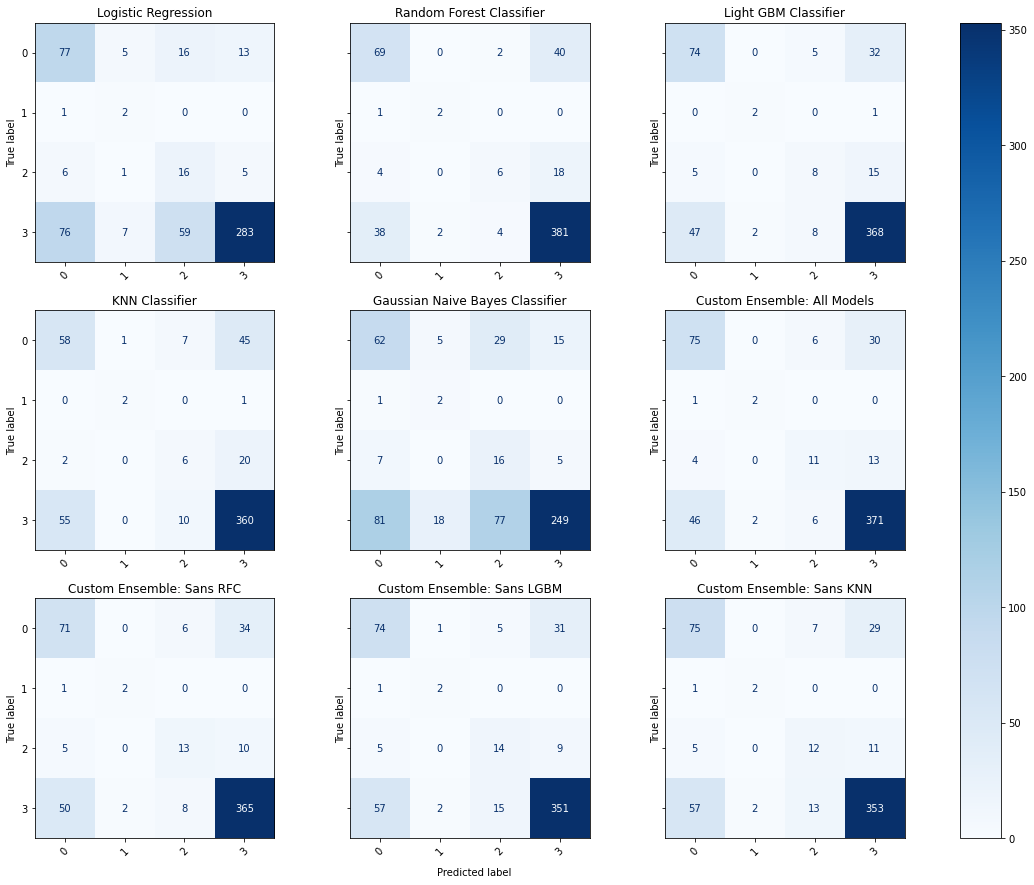

In [28]:
pred_dict = {'Logistic Regression': lm_pred,
             'Random Forest Classifier': rfc_pred,
             'Light GBM Classifier': lgb_pred,
             'KNN Classifier': knn_pred,
             'Gaussian Naive Bayes Classifier': gnb_pred,
             'Custom Ensemble: All Models': pred_all,
             'Custom Ensemble: Sans RFC': pred_sans_rfc,
             'Custom Ensemble: Sans LGBM': pred_sans_lgb,
             'Custom Ensemble: Sans KNN': pred_sans_knn}

print_cms(pred_dict, y_test)

Although these visualizations do clarify the relative performance of our models, the corresponding shading doesn't offer much value because of the large class imbalance in our output. We will now normalize the confusion matrices against the ground truth label to better understand how our models are performing.

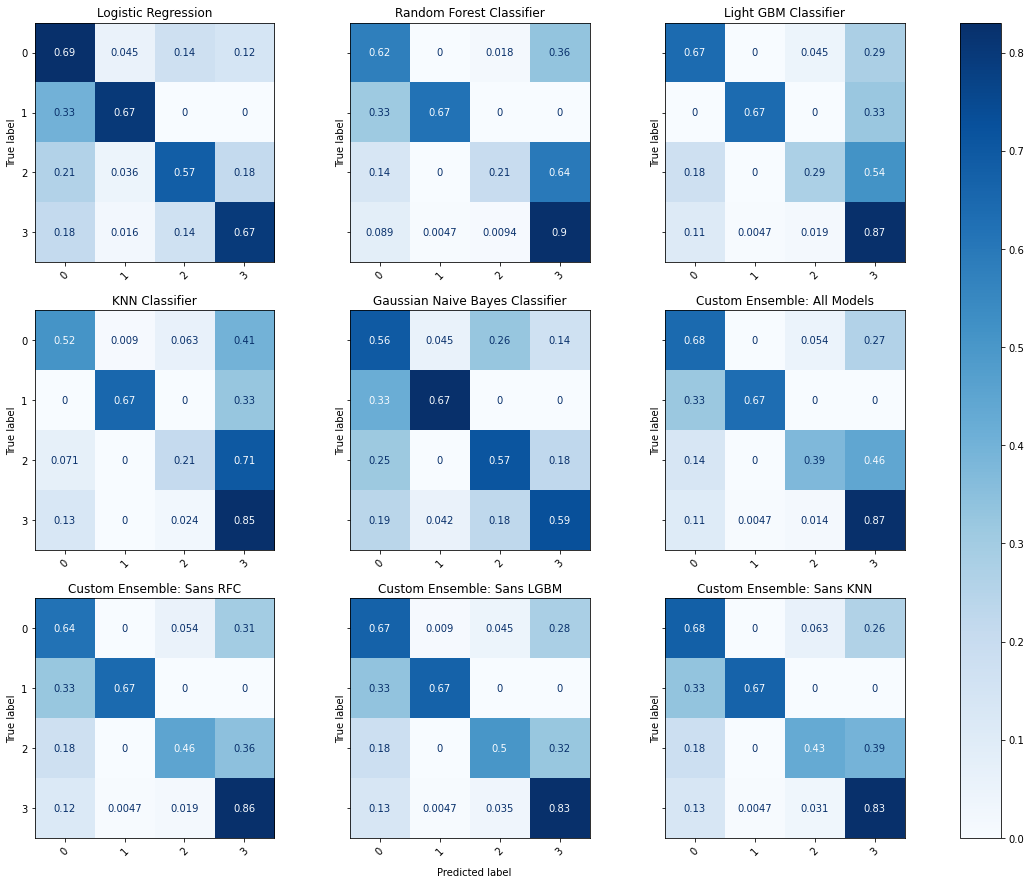

In [29]:
print_cms(pred_dict, y_test, normalize='true')

Our **Custom Ensemble: All Models** model and **Custom Ensemble: Sans KNN** model have the best performance, but in different areas.
- The **Custom Ensemble: Sans KNN** model outperforms the **Custom Ensemble: All Models** model on classifying Risk Class 2 (important), but it performs worse on Risk Class 1 (important) and Risk Class 4 (not as important). Overall, the **Custom Ensemble: All Models** model edges further ahead with a better overall F1 score and accuracy.
- At first glance, the **Logistic Regression** model or the **Gaussian Naive Bayes** model seem to be a strong contender, because of the higher values in the diagonal and resultant darker shading. However, this exposes the folly of using just confusion matrices in our model evaluation. Although those two models correctly classifies more projects in Risk Classes 0-2, they do so by incorrectly classifying many projects in Risk Class 4, as is evident by the lower precision, recall, and F1 scores for those models.
- The other custom emsembles come close, but the precision/recall/F1 values for these one are better overall.

[Back to Top](#top)

<a class="anchor" id="step-4"></a>

## Testing Augmented Inputs

We will now try to augment the description of the projects to include more than the *Title* and *Abstract* features. To do so, we need to decide which of the available features can add value beyond the two we have already selected.

### Prep Dataframe for Prototyping

#### Remove Irrelevant Features

First, we remove any columns containing data unavailable at the beginning of the project.
- _Lesson(s) Learned_ was used to generate the risk classifications. Logically, we cannot use it as an input. Regardless, it is information that comes to light during the course of the project. Therefore, this column will be dropped.
- The other columns that either relate to _Lesson(s) Learned_ or are post-facto include:
    - _Recommendation(s)_
    - _Date Lesson Occurred_
    - _Driving Event_
    - _Evidence_
    - _The related NASA policy(s), standard(s), handbook(s), procedure(s) or other rules_
    - _From what phase of the program or project was this lesson learned captured?_
    - _Where (other lessons, presentations, publications, etc.)?_
- _Publish Date_ is also a post-facto column. Furthermore, we don't expect the publication date to actually impact the risk classification.

In [30]:
df_augmented = df_master.copy().drop('index', axis=1)

if 'Lesson(s) Learned' in df_augmented.columns:
    df_augmented.drop(['Lesson(s) Learned', 'Recommendation(s)', 'Date Lesson Occurred', 'Driving Event', 'Evidence',
                       'The related NASA policy(s), standard(s), handbook(s), procedure(s) or other rules',
                       'From what phase of the program or project was this lesson learned captured?',
                       'Where (other lessons, presentations, publications, etc.)?', 'Publish Date'], inplace=True, axis=1)

display(df_augmented.shape)
df_augmented.head()

(2067, 9)

,Lesson ID,Title,Abstract,Organization,Project / Program,NASA Mission Directorate(s),Sensitivity,Topics,Risk Class
0,30004,Relationship of Government and Contractor Risk...,The purpose of this lesson is to highlight the...,LaRC,Radiation Budget Instrument,"Aeronautics Research, Human Exploration and Op...",Public,"Procurement, Small Business & Industrial Relat...",4
1,30101,Cable Harness Wiring and Connector Anomalies C...,Early indications show that the commercial spa...,NESC,"Space Shuttle Program, Commercial Crewed Space...",Human Exploration and Operations,Public,"Flight Equipment, Ground Operations, Hardware,...",4
2,29801,Best Practices for the Elemental Profiling of ...,Trace contaminants in high-purity hydrazine (H...,NESC,All NASA missions using high purity hydrazine ...,"Human Exploration and Operations, Science, Spa...",Public,"Ground Operations, Launch Vehicle, Parts, Mate...",4
3,29702,Integration and Dependency Between Different A...,During the Radiological Control Center (RADCC)...,KSC,Radiological Control Center (RADCC),Human Exploration and Operations,Public,"Engineering Design, Integration and Testing, S...",4
4,29103,Copper Tube Pinch Failure,While pinching copper tubes is a standard prac...,KSC,Mass Spectrometer observing lunar operations (...,"Human Exploration and Operations, Space Techno...",Public,"Engineering Design, Integration and Testing, M...",4


#### Categorical Feature Analysis

Next, aside from _Title_ and _Abstract_, we will try to identify which other categorical features (if any) may offer value to the text-based description of the project. We start by checking how many unique values exist for each categorical feature.

In [31]:
df_augmented.iloc[:,3:].nunique()

Organization                    15
Project / Program              200
NASA Mission Directorate(s)     25
Sensitivity                      1
Topics                         435
Risk Class                       4
dtype: int64

- _Organization_ seems to be a straightforward categorical column that provides value and has a manageable number of distinct values. We will keep this in our analysis, but we'll append 'Org' to the front of each value so it does not get removed in our preprocessing steps.
- _Project / Program_ doesn't seem to have a standard format for its values. Furthermore, it has 200 values for a total 2000 different projects. We think including this feature in our analysis would add too many columns for not much value. We will remove this column from analysis and try to see what our initial results look like, before considering including the text from this column in our inputs.
- _NASA Mission Directorate(s)_ seems to be comma-separated values. There may be value in adding them into our analysis. We will need to reformat the inputs to keep track of each mission directoraate separately (e.g. changing 'Aeronautics Research' to 'Directorate_Aeronautics_Research' so our analysis will consider it one term).
- _Sensitivity_ has only one value in the entire column. It is useless and will therefore be removed from our analysis.
- _Topics_ seems to be similar to _NASA Mission Directorate(s)_. We will handle it similarly.

In [32]:
# drop the columns we decided to remove from further analysis
if 'Project / Program' in df_augmented.columns:
    df_augmented.drop(['Project / Program', 'Sensitivity'], axis=1, inplace=True)

# modify contents of columns as described above
def fix_column_values(text, prefix):
    if text == 'nan':
        return ''
        
    text_to_return = ''
    text_split = text.split(',')
    for directorate in text_split:
        text_to_return += prefix + directorate.strip().replace(' ', '_') + ' '
    
    return text_to_return.strip().lower()

# fix the columns, and then drop the original columns
if 'Organization' in df_augmented.columns:
    df_augmented['Fixed Organization'] = 'org_' + df_augmented['Organization'].astype(str).apply(str.lower)
    df_augmented['Fixed Directorates'] = df_augmented['NASA Mission Directorate(s)'].astype(str).apply(fix_column_values, prefix='Directorate_')
    df_augmented['Fixed Topics'] = df_augmented['Topics'].astype(str).apply(fix_column_values, prefix='Topic_')
    df_augmented.drop(['Organization', 'NASA Mission Directorate(s)', 'Topics'], axis=1, inplace=True)

display(df_augmented.shape)
df_augmented.head()

(2067, 7)

,Lesson ID,Title,Abstract,Risk Class,Fixed Organization,Fixed Directorates,Fixed Topics
0,30004,Relationship of Government and Contractor Risk...,The purpose of this lesson is to highlight the...,4,org_larc,directorate_aeronautics_research directorate_h...,topic_procurement topic_small_business_&_indus...
1,30101,Cable Harness Wiring and Connector Anomalies C...,Early indications show that the commercial spa...,4,org_nesc,directorate_human_exploration_and_operations,topic_flight_equipment topic_ground_operations...
2,29801,Best Practices for the Elemental Profiling of ...,Trace contaminants in high-purity hydrazine (H...,4,org_nesc,directorate_human_exploration_and_operations d...,topic_ground_operations topic_launch_vehicle t...
3,29702,Integration and Dependency Between Different A...,During the Radiological Control Center (RADCC)...,4,org_ksc,directorate_human_exploration_and_operations,topic_engineering_design topic_integration_and...
4,29103,Copper Tube Pinch Failure,While pinching copper tubes is a standard prac...,4,org_ksc,directorate_human_exploration_and_operations d...,topic_engineering_design topic_integration_and...


### Prep Dataframe for Augmented Modeling

Next, we need to combine all of the features into one block of text.

In [33]:
if 'Title' in df_augmented.columns:
    df_augmented['Description'] = df_augmented['Title'].astype(str) + ' ' +\
                                  df_augmented['Abstract'].astype(str) + ' ' +\
                                  df_augmented['Fixed Organization'].astype(str) + ' ' +\
                                  df_augmented['Fixed Directorates'].astype(str) + ' ' +\
                                  df_augmented['Fixed Topics'].astype(str)
    df_augmented.drop(['Title', 'Abstract', 'Fixed Organization', 'Fixed Directorates', 'Fixed Topics'], axis=1, inplace=True)

display(df_augmented.shape)
df_augmented.head()

(2067, 3)

,Lesson ID,Risk Class,Description
0,30004,4,Relationship of Government and Contractor Risk...
1,30101,4,Cable Harness Wiring and Connector Anomalies C...
2,29801,4,Best Practices for the Elemental Profiling of ...
3,29702,4,Integration and Dependency Between Different A...
4,29103,4,Copper Tube Pinch Failure While pinching coppe...


Like we did in the prototyping phase, we will replace the _Description_ column with a PCA representation.

In [34]:
if 'Description' in df_augmented.columns:
    pca_matrix_aug, tfidf_vectorizer_aug, pca_vectorizer_aug = create_pca_representation(df_augmented['Description'], 'prototype')
    df_augmented.drop('Description', axis=1, inplace=True)
    df_augmented = pd.concat([df_augmented, pd.DataFrame(pca_matrix_aug)], axis=1)

display(df_augmented.shape)
df_augmented.head()

(2067, 102)

,Lesson ID,Risk Class,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,30004,4,-0.027343,-0.206953,0.028497,-0.142765,0.116207,0.030320,0.027532,0.006033,...,0.043647,0.004672,0.013972,0.048265,-0.030932,-0.053292,0.050686,-0.030627,-0.003499,-0.006799
1,30101,4,0.081710,-0.044084,-0.049942,-0.057494,-0.130958,-0.081129,-0.017990,-0.015218,...,0.092094,-0.071480,-0.061221,0.004660,-0.027905,0.149701,-0.018921,0.060095,0.077552,-0.003453
2,29801,4,-0.058111,-0.045619,-0.001553,0.029524,-0.039855,-0.023989,0.010627,-0.020775,...,0.082161,-0.045434,0.039285,0.002562,-0.021729,-0.042321,-0.006855,-0.005385,0.003874,0.028212
3,29702,4,-0.029450,-0.044395,-0.036080,0.029603,-0.032345,-0.091593,-0.024204,-0.076670,...,-0.018111,-0.029592,0.021137,0.006203,0.087848,-0.021521,0.028546,-0.036935,0.058806,-0.068857
4,29103,4,-0.055857,0.003103,-0.028929,0.034995,-0.017411,-0.035518,-0.006991,-0.029616,...,0.019773,0.013006,-0.007108,-0.075842,-0.008112,0.059527,0.110251,0.086196,0.010388,0.024514


We now split the data into a training and testing set using the `split_data()` helper function.

In [35]:
X_train_aug, X_test_aug, y_train_aug, y_test_aug = split_data(df_augmented)

print('Training Output Variable Distribution')
display(y_train_aug.value_counts())
print()
print('Testing Output Variable Distribution')
display(y_test_aug.value_counts())


Training Output Variable Distribution


4    993
0    241
2     62
1      7
Name: Risk Class, dtype: int64


Testing Output Variable Distribution


4    426
0    103
2     27
1      3
Name: Risk Class, dtype: int64

### Multi-Class Modeling on Augmented Inputs

We will now train and tune the same models as we tried in the prototyping phase, to see if the augmented inputs result in better model performance.

***
#### Logistic Regression
***

In [36]:
best_lm_aug, lm_pred_aug, lm_metrics_aug = model_logisticregression_tuned(X_train_aug, y_train_aug, X_test_aug, y_test_aug)
print(lm_metrics_aug)

{'C': 0.0001, 'penalty': 'none', 'solver': 'newton-cg'}
              precision    recall  f1-score   support

           0      0.514     0.718     0.599       103
           1      0.000     0.000     0.000         3
           2      0.185     0.556     0.278        27
           4      0.931     0.725     0.815       426

    accuracy                          0.712       559
   macro avg      0.407     0.500     0.423       559
weighted avg      0.813     0.712     0.745       559



***
#### Random Forest Classifier
***

In [37]:
best_rfc_aug, rfc_pred_aug, rfc_metrics_aug = model_randomforestclassifier_tuned(X_train_aug, y_train_aug, X_test_aug, y_test_aug)
print(rfc_metrics_aug)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'criterion': 'entropy', 'max_depth': 8, 'max_features': 0.25, 'n_estimators': 300}
              precision    recall  f1-score   support

           0      0.592     0.592     0.592       103
           1      0.000     0.000     0.000         3
           2      0.400     0.296     0.340        27
           4      0.864     0.880     0.872       426

    accuracy                          0.794       559
   macro avg      0.464     0.442     0.451       559
weighted avg      0.787     0.794     0.790       559



***
#### Light Gradient Booosted Model Classifier
***

In [38]:
best_lgb_aug, lgb_pred_aug, lgb_metrics_aug = model_lgbmclassifier_tuned(X_train_aug, y_train_aug, X_test_aug, y_test_aug)
print(lgb_metrics)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
{'max_depth': 15, 'min_split_gain': 0, 'num_leaves': 10, 'reg_alpha': 1.0, 'reg_lambda': 1.0}
              precision    recall  f1-score   support

           0      0.587     0.667     0.624       111
           1      0.500     0.667     0.571         3
           2      0.381     0.286     0.327        28
           4      0.885     0.866     0.875       425

    accuracy                          0.797       567
   macro avg      0.588     0.621     0.599       567
weighted avg      0.800     0.797     0.797       567



***
#### K Nearest Neighbors Classifier
***

In [39]:
best_knn_aug, knn_pred_aug, knn_metrics_aug = model_knnclassifier_tuned(X_train_aug, y_train_aug, X_test_aug, y_test_aug)
print(knn_metrics_aug)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'algorithm': 'auto', 'n_neighbors': 3, 'p': 3, 'weights': 'distance'}
              precision    recall  f1-score   support

           0      0.536     0.505     0.520       103
           1      0.000     0.000     0.000         3
           2      0.217     0.185     0.200        27
           4      0.841     0.866     0.853       426

    accuracy                          0.762       559
   macro avg      0.399     0.389     0.393       559
weighted avg      0.750     0.762     0.756       559



***
#### Gaussian Naive Bayes Classifier
***

In [40]:
best_gnb_aug, gnb_pred_aug, gnb_metrics_aug = model_gnbclassifier_tuned(X_train_aug, y_train_aug, X_test_aug, y_test_aug)
print(gnb_metrics_aug)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'var_smoothing': 0.0004832930238571757}
              precision    recall  f1-score   support

           0      0.465     0.650     0.543       103
           1      0.000     0.000     0.000         3
           2      0.134     0.556     0.216        27
           4      0.904     0.638     0.748       426

    accuracy                          0.633       559
   macro avg      0.376     0.461     0.377       559
weighted avg      0.781     0.633     0.681       559



We will also try to ensemble our models like we did in the prototyping phase.

***
#### Custom Ensembles
***

In [41]:
# create a custom ensemble of all of the above methods
estimators_all_aug = [('lm', best_lm_aug), ('rfc', best_rfc_aug), ('lgb', best_lgb_aug), ('knn', best_knn_aug), ('gnb', best_gnb_aug)]
ensemble_all_aug = VotingClassifier(estimators_all_aug, voting='soft')

#fit model to training data
ensemble_all_aug.fit(X_train_aug, y_train_aug)
pred_all_aug = ensemble_all_aug.predict(X_test_aug)

print(classification_report(y_test_aug, pred_all_aug, digits=3))


              precision    recall  f1-score   support

           0      0.619     0.680     0.648       103
           1      0.000     0.000     0.000         3
           2      0.370     0.370     0.370        27
           4      0.890     0.871     0.880       426

    accuracy                          0.807       559
   macro avg      0.470     0.480     0.475       559
weighted avg      0.810     0.807     0.808       559



In [42]:
# create a custom ensemble of all models except for RFC
estimators_sans_rfc_aug = [('lm', best_lm_aug), ('lgb', best_lgb_aug), ('knn', best_knn_aug), ('gnb', best_gnb_aug)]
ensemble_sans_rfc_aug = VotingClassifier(estimators_sans_rfc_aug, voting='soft')

#fit model to training data
ensemble_sans_rfc_aug.fit(X_train_aug, y_train_aug)
pred_sans_rfc_aug = ensemble_sans_rfc_aug.predict(X_test_aug)

print(classification_report(y_test_aug, pred_sans_rfc_aug, digits=3))

              precision    recall  f1-score   support

           0      0.595     0.670     0.630       103
           1      0.000     0.000     0.000         3
           2      0.303     0.370     0.333        27
           4      0.892     0.854     0.873       426

    accuracy                          0.792       559
   macro avg      0.448     0.474     0.459       559
weighted avg      0.804     0.792     0.797       559



In [43]:
# create a custom ensemble of all models except for LGBM
estimators_sans_lgb_aug = [('lm', best_lm_aug), ('rfc', best_rfc_aug), ('knn', best_knn_aug), ('gnb', best_gnb_aug)]
ensemble_sans_lgb_aug = VotingClassifier(estimators_sans_lgb_aug, voting='soft')

#fit model to training data
ensemble_sans_lgb_aug.fit(X_train_aug, y_train_aug)
pred_sans_lgb_aug = ensemble_sans_lgb_aug.predict(X_test_aug)

print(classification_report(y_test_aug, pred_sans_lgb_aug, digits=3))

              precision    recall  f1-score   support

           0      0.574     0.641     0.606       103
           1      0.000     0.000     0.000         3
           2      0.343     0.444     0.387        27
           4      0.889     0.850     0.869       426

    accuracy                          0.787       559
   macro avg      0.452     0.484     0.465       559
weighted avg      0.800     0.787     0.793       559



In [44]:
# create a custom ensemble of all models except for KNN
estimators_sans_knn_aug = [('lm', best_lm_aug), ('rfc', best_rfc_aug), ('lgb', best_lgb_aug), ('gnb', best_gnb_aug)]
ensemble_sans_knn_aug = VotingClassifier(estimators_sans_knn_aug, voting='soft')

#fit model to training data
ensemble_sans_knn_aug.fit(X_train_aug, y_train_aug)
pred_sans_knn_aug = ensemble_sans_knn_aug.predict(X_test_aug)

print(classification_report(y_test_aug, pred_sans_knn_aug, digits=3))

              precision    recall  f1-score   support

           0      0.584     0.709     0.640       103
           1      0.000     0.000     0.000         3
           2      0.344     0.407     0.373        27
           4      0.897     0.843     0.869       426

    accuracy                          0.792       559
   macro avg      0.456     0.490     0.471       559
weighted avg      0.808     0.792     0.798       559



### Augmenting Model Results

#### Confusion Matrices

We will jump straight to the normalized confusion matrices for the augmented models.

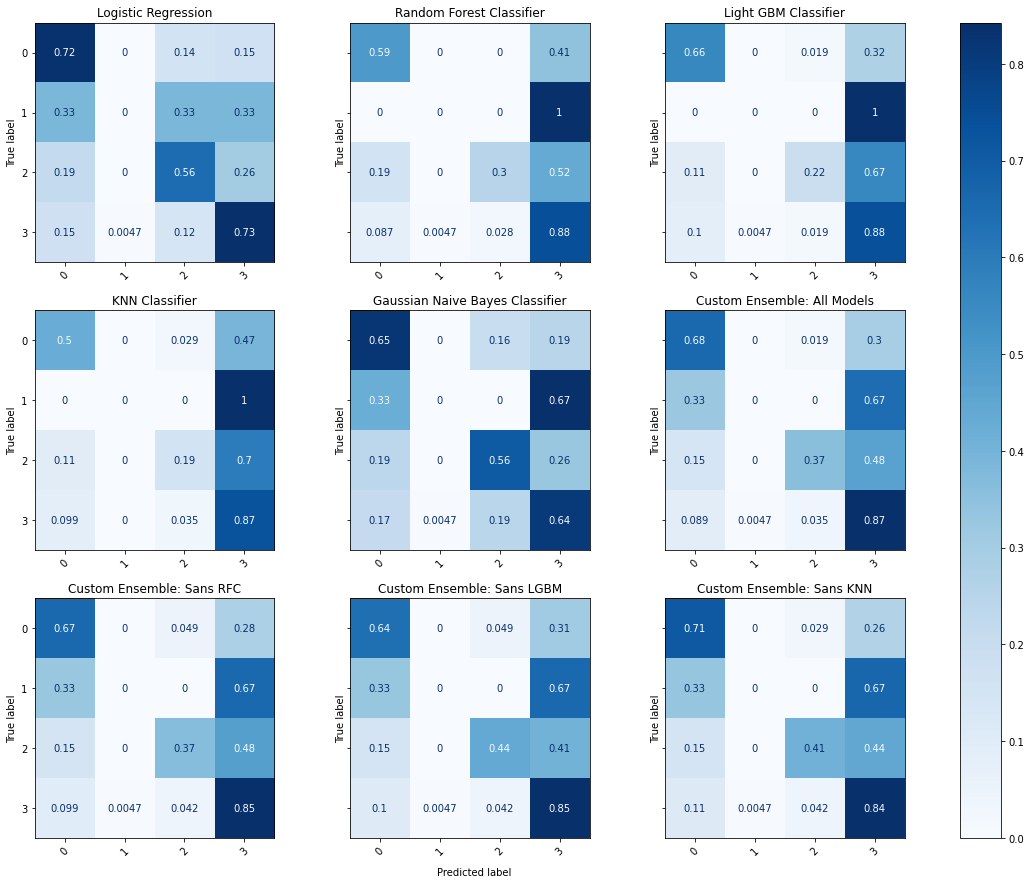

In [45]:
pred_dict_aug = {'Logistic Regression': lm_pred_aug,
                 'Random Forest Classifier': rfc_pred_aug,
                 'Light GBM Classifier': lgb_pred_aug,
                 'KNN Classifier': knn_pred_aug,
                 'Gaussian Naive Bayes Classifier': gnb_pred_aug,
                 'Custom Ensemble: All Models': pred_all_aug,
                 'Custom Ensemble: Sans RFC': pred_sans_rfc_aug,
                 'Custom Ensemble: Sans LGBM': pred_sans_lgb_aug,
                 'Custom Ensemble: Sans KNN': pred_sans_knn_aug}

print_cms(pred_dict_aug, y_test_aug, normalize='true')

Our augmented inputs result in models that perform much more poorly than the original prototyped models, where the inputs were just the *Title* and the *Abstract*. This indicates that the additional features we added to our analysis are adding more noise and are failing to provide additional predictive value for risk classification. This actually is a good thing, because it means that we can more accurately predict risk classification with simply the *Title* and *Abstract* of a given project.

[Back to Top](#top)

<a class="anchor" id="step-5"></a>

## Results and Saving Models to Project

### Results

Our ensembled prototype model, **Custom Ensemble: All Models** is the best performing model that we have. Let's take a look at its model metrics once more.

In [46]:
print(classification_report(y_test, pred_all, digits=3))

              precision    recall  f1-score   support

           0      0.595     0.676     0.633       111
           1      0.500     0.667     0.571         3
           2      0.478     0.393     0.431        28
           4      0.896     0.873     0.884       425

    accuracy                          0.810       567
   macro avg      0.617     0.652     0.630       567
weighted avg      0.814     0.810     0.811       567



This ensemble model has an overall accuracy of 81% and and weighted average F-1 Score of 0.811. It can categorize the potential risk of a project using just the *Title* and *Abstract* as inputs. Each of the five models in the ensemble (the `Logistic Regression` classifier, the `Random Forest Classifier` model, `the Light Gradient Boosted Classifier` model, `the K Nearest Neighbor` classifier, and the `Gaussian Naive Bayes` classifier) contribute to the overall ensemble's performance, resulting in better performance as a whole when compared to each individual part.

To allow NASA to use this ensemble model to categorize the risk of future projects, we will now save each of these models (along with the ensembled model) to the project directory. These will be accessed by the [ClassifyRisk.py](../scripts/classify_risk.py) script. For an example of how to use this script to classify future projects, please take a look at [ClassifyRisk.ipynb](ClassifyRisk.ipynb).

In [47]:
models_dict = {'../models/model_lm.pkl': best_lm,
               '../models/model_rfc.pkl': best_rfc,
               '../models/model_lgb.pkl': best_lgb,
               '../models/model_knn.pkl': best_knn,
               '../models/model_gnb.pkl': best_gnb,
               '../models/model_ensemble_all.pkl': ensemble_all}

for f_name, model in models_dict.items():
    with open(f_name, 'wb') as f:
        pickle.dump(model, f)

The script will also need the tfidf_vectorizer and pca_vectorizer to preprocess future project descriptions.

In [17]:
with open('../models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
with open('../models/pca_vectorizer.pkl', 'wb') as f:
    pickle.dump(pca_vectorizer, f)

[Back to Top](#top)